## PDF Text extraction & chunking

### PDF to text

PDFs contain rich formatting that needs to be extracted as clean text for AI processing. 

Modern libraries like `docling` can preserve document structure while converting to text format, making the text easier to process while maintaining semantic relationships.

Inspect a PDF converted with `docling`:

In [1]:
from pathlib import Path

md_filepath = Path("data/parsed/amazon-2025-08-8k-excerpts-parsed-text.md")
md_txt = md_filepath.read_text()
print(md_txt[:500])

amazon

<!-- image -->

## AMAZON.COM ANNOUNCES SECOND QUARTER RESULTS

SEATTLE-(BUSINESS WIRE) July 31, 2025-Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results for its second quarter ended June 30, 2025.

- Net sales increased 13% to $167.7 billion in the second quarter, compared with $148.0 billion in second quarter 2024. Excluding the $1.5 billion favorable impact from year-over-year changes in foreign exchange rates throughout the quarter, net sales increased 12% compared with


Tables preserve their formatting:

In [2]:
table_example = md_txt.split("## Consolidated Statements of Operations")[1]
print(table_example[:2000])



(in millions, except per share data)

(unaudited)

|                                                                    | Three Months Ended June 30,   | Three Months Ended June 30,   | Six Months Ended June 30,   | Six Months Ended June 30,   |
|--------------------------------------------------------------------|-------------------------------|-------------------------------|-----------------------------|-----------------------------|
|                                                                    | 2024                          | 2025                          | 2024                        | 2025                        |
| Net product sales                                                  | $ 61,569                      | $ 68,246                      | $ 122,484                   | $ 132,216                   |
| Net service sales                                                  | 86,408                        | 99,456                        | 168,806                     | 19

### Chunking

Raw text from PDFs is often too long for AI models to process effectively. Chunking breaks documents into smaller, manageable pieces while preserving context. 

#### Chunk by text length

Fixed-length chunks are simple but can break sentences or paragraphs mid-thought. This approach is fast and predictable, making it suitable for initial processing or when document structure is uniform.

![images/chunking_why.png](images/chunking_why.png)

Different chunking strategies serve different use cases. 

![images/chunking_methods.png](images/chunking_methods.png)

Let's try a few options:

#### Chunk by text length with overlap

Overlapping chunks help maintain context across boundaries. 

When a concept spans multiple chunks, the overlap helps to capture it. This is especially important for maintaining semantic coherence in search and retrieval systems.

In [3]:
def get_chunks_by_length_with_overlap(src_text: str, chunk_length: int = 500, overlap: int = 100) -> list[str]:
    """
    Split text into chunks of approximately `chunk_length` characters.
    """
    chunks = []
    for i in range(0, len(src_text), chunk_length):
        chunks.append(src_text[i:i + chunk_length + overlap])
    return chunks

In [4]:
# STUDENT TODO
# Chunk `md_text_1` with `get_chunks_by_length_with_overlap`
# Inspect the first 3 or so chunks
# START_SOLUTION
chunks = get_chunks_by_length_with_overlap(md_txt)

for chunk in chunks[:3]:
    print(f"Chunk length: {len(chunk)}\n" + "-"*20)
    print(chunk)
# END_SOLUTION

Chunk length: 600
--------------------
amazon

<!-- image -->

## AMAZON.COM ANNOUNCES SECOND QUARTER RESULTS

SEATTLE-(BUSINESS WIRE) July 31, 2025-Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results for its second quarter ended June 30, 2025.

- Net sales increased 13% to $167.7 billion in the second quarter, compared with $148.0 billion in second quarter 2024. Excluding the $1.5 billion favorable impact from year-over-year changes in foreign exchange rates throughout the quarter, net sales increased 12% compared with second quarter 2024.
- North America segment sales increased 11% year-over-year to $100.1 billion.

Chunk length: 600
--------------------
 second quarter 2024.
- North America segment sales increased 11% year-over-year to $100.1 billion.
- International segment sales increased 16% year-over-year to $36.8 billion, or increased 11% excluding changes in foreign exchange rates.
- AWS segment sales increased 17.5% year-over-year to $30.9 billion.
- Operating i

#### Chunk using markers

Using document markers (like headers) creates chunks that respect natural document boundaries. 

This approach preserves semantic structure and is ideal for documents with clear hierarchical organization like reports, manuals, or academic papers.

In [5]:
def get_chunks_using_markers(src_text: str) -> list[str]:
    """
    Split the source text into chunks using markers.
    """
    marker = "\n##"

    # Split by marker and reconstruct with markers (except first chunk)
    parts = src_text.split(marker)
    chunks = []

    # Add first chunk if it exists and isn't empty
    if parts[0].strip():
        chunks.append(parts[0].strip())

    # Add remaining chunks with markers reattached
    for part in parts[1:]:
        if part.strip():
            chunks.append(marker + part.strip())

    return chunks

In [6]:
md_file_1 = Path("data/parsed/amazon-2025-08-8k-excerpts-parsed-text.md")
md_text_1 = md_file_1.read_text(encoding="utf-8")

# STUDENT TODO
# Chunk `md_text_1` with `get_chunks_using_markers`
# Inspect the first few chunks
# START_SOLUTION
chunks = get_chunks_using_markers(md_text_1)

for chunk in chunks[:3]:
    print(f"Chunk length: {len(chunk)}\n" + "-"*20)
    print(chunk)
# END_SOLUTION

Chunk length: 22
--------------------
amazon

<!-- image -->
Chunk length: 7588
--------------------

##AMAZON.COM ANNOUNCES SECOND QUARTER RESULTS

SEATTLE-(BUSINESS WIRE) July 31, 2025-Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results for its second quarter ended June 30, 2025.

- Net sales increased 13% to $167.7 billion in the second quarter, compared with $148.0 billion in second quarter 2024. Excluding the $1.5 billion favorable impact from year-over-year changes in foreign exchange rates throughout the quarter, net sales increased 12% compared with second quarter 2024.
- North America segment sales increased 11% year-over-year to $100.1 billion.
- International segment sales increased 16% year-over-year to $36.8 billion, or increased 11% excluding changes in foreign exchange rates.
- AWS segment sales increased 17.5% year-over-year to $30.9 billion.
- Operating income increased to $19.2 billion in the second quarter, compared with $14.7 billion in second quarter 

## Working with PDFs with images

PDFs contain more than rich formatting - they have images!

Run the cells below to convert PDF data to images (this should take about a minute). 

In [7]:
try:
    import pymupdf
except ImportError:
    %pip install -Uqq pymupdf

In [8]:
%%bash
python pdf_to_img.py WEF*.pdf
echo "Images extracted from AI report PDF"

Converting data/pdfs/WEF_Artificial_Intelligence_in_Financial_Services_2025.pdf to images...
Converted 27 pages to images
Images extracted from AI report PDF


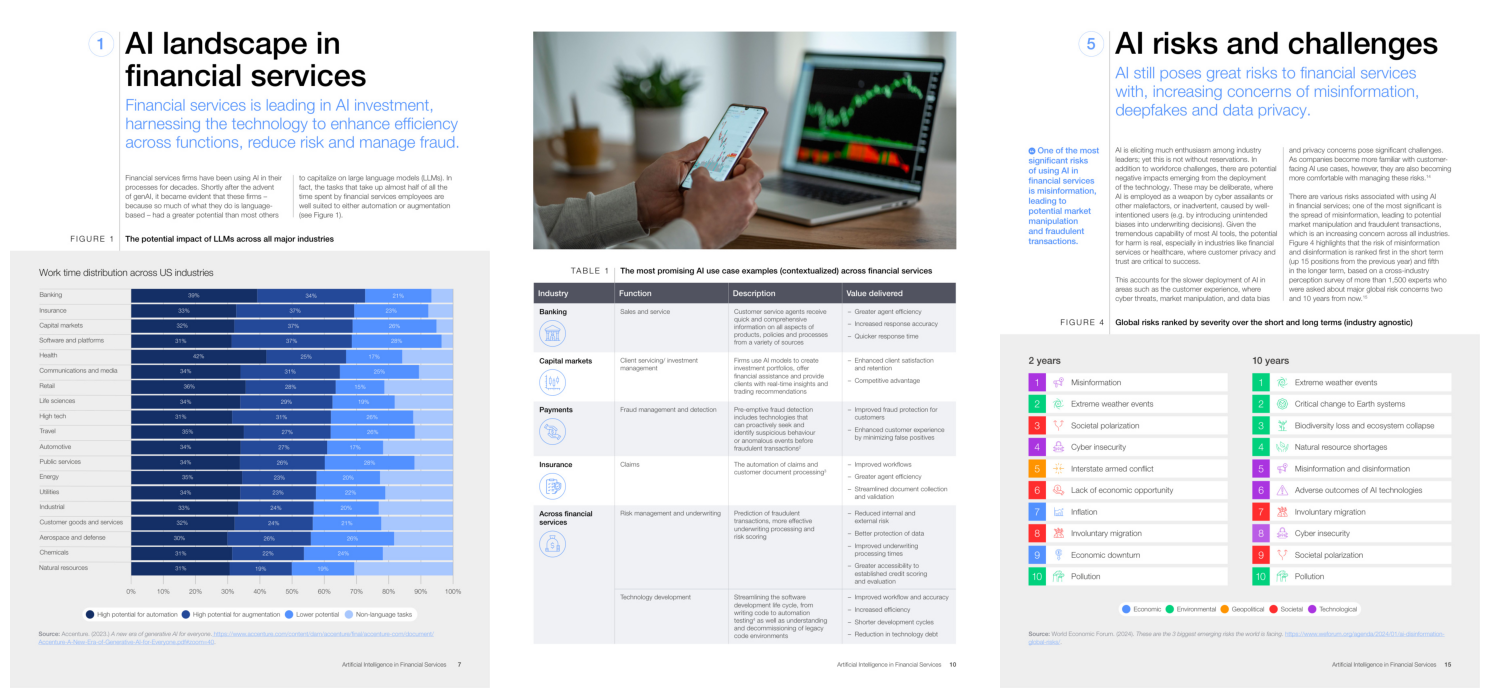

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

images = [
    f"data/imgs/WEF_Artificial_Intelligence_in_Financial_Services_2025_07_of_27.jpg",
    f"data/imgs/WEF_Artificial_Intelligence_in_Financial_Services_2025_10_of_27.jpg",
    f"data/imgs/WEF_Artificial_Intelligence_in_Financial_Services_2025_15_of_27.jpg"
]

fig, axes = plt.subplots(1, 3, figsize=(15, 40))

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Approach 1 - Extract text and images separately

Some libraries (like `docling`) can extract text and images from PDFs, and convert them into Markdown files.

Here, we've pre-converted this PDF into markdown.

In [10]:
from pathlib import Path

md_filepath = Path("data/parsed/WEF_Artificial_Intelligence_in_Financial_Services_2025-parsed-w-imgs.md")
md_txt = md_filepath.read_text()
print(md_txt[:1000])

AI Governance Alliance

In collaboration with Accenture

Transformation of Industries in the Age of AI

## Artificial Intelligence in Financial Services

WHI T E   P A P E R J A N U A R Y   2 0 2 5

![Image](data/parsed/WEF_Artificial_Intelligence_in_Financial_Services_2025-parsed-w-imgs_artifacts/image_000000_da5e9400ab3ca349547e766e7077edfc6272560081af7fb1ca6ff8d94752f505.png)

## Contents

| Reading guide     | Reading guide                             |   3 |
|-------------------|-------------------------------------------|-----|
| Foreword          | Foreword                                  |   4 |
| Executive summary | Executive summary                         |   5 |
| Introduction      | Introduction                              |   6 |
| 1                 | AI landscape in financial services        |   7 |
| 2                 | Seeing early value from AI implementation |  11 |
| 3                 | Moving towards an AI-powered future       |  12 |
| 4                 | AI in 

#### Chunking text files with images

More complex than just text, since we need to handle images as well.

- Must include entire image string in the chunk
- When vectorizing, optionally include base64 of image
    - Your embedding model must be multimodal

Chunking becomes more complex.

One method: try a specialized library like `chonkie` to handle this

Chonkie offers a variety of chunking strategies:

<img src="images/chonkie_methods.png" />

There isn't going to be a "one size fits all" solution for chunking PDFs with images. But these libraries can help you get started.

Let's try a couple of different approaches:

In [11]:
%pip install -Uqq "chonkie[all]"

Note: you may need to restart the kernel to use updated packages.


In [12]:
from chonkie import RecursiveChunker

# Initialize the recursive chunker to chunk Markdown
chunker = RecursiveChunker.from_recipe("markdown", lang="en")

In [13]:
chunk_texts = chunker.chunk(md_txt)

In [14]:
import textwrap

for chunk in chunk_texts[:5]:
    print(f"\n" + "=" * 40)
    print(f"Token count: {chunk.token_count}")
    print(f"Chunk text:")
    wrapped_text = textwrap.fill(chunk.text[:500]+"...", width=80)
    print(textwrap.indent(wrapped_text, "    "))


Token count: 1477
Chunk text:
    AI Governance Alliance  In collaboration with Accenture  Transformation of
    Industries in the Age of AI  ## Artificial Intelligence in Financial Services
    WHI T E   P A P E R J A N U A R Y   2 0 2 5  ![Image](data/parsed/WEF_Artificial
    _Intelligence_in_Financial_Services_2025-parsed-w-imgs_artifacts/image_000000_da
    5e9400ab3ca349547e766e7077edfc6272560081af7fb1ca6ff8d94752f505.png)  ## Contents
    | Reading guide     | Reading guide                             |   3 |
    |-------------------|-----------...

Token count: 670
Chunk text:
    ## Disclaimer  This document is published by the World Economic Forum as a
    contribution to a project, insight area or interaction. The findings,
    interpretations and conclusions expressed herein are a result of a collaborative
    process facilitated and endorsed by the World Economic Forum but whose results
    do not necessarily represent the views of the World Economic Forum, nor the
    en

Let's try a "semantic" chunker:

In [15]:
from chonkie import SemanticChunker

# Basic initialization with default parameters
chunker = SemanticChunker(
    embedding_model="minishlab/potion-base-8M",  # Default model
    threshold=0.5,                               # Similarity threshold (0-1) or (1-100) or "auto"
    chunk_size=2048,                             # Maximum tokens per chunk
    min_sentences=1                              # Initial sentences per chunk
)

In [16]:
chunk_texts = chunker.chunk(md_txt)

In [17]:
for chunk in chunk_texts[:5]:
    print(f"\n" + "=" * 40)
    print(f"Token count: {chunk.token_count}")
    print(f"Chunk text:")
    wrapped_text = textwrap.fill(chunk.text[:500]+"...", width=80)
    print(textwrap.indent(wrapped_text, "    "))


Token count: 43
Chunk text:
    AI Governance Alliance  In collaboration with Accenture  Transformation of
    Industries in the Age of AI  ## Artificial Intelligence in Financial Services
    WHI T E   P A P E R J A N U A R Y   2 0 2 5 ...

Token count: 101
Chunk text:
     ![Image](data/parsed/WEF_Artificial_Intelligence_in_Financial_Services_2025-
    parsed-w-imgs_artifacts/image_000000_da5e9400ab3ca349547e766e7077edfc6272560081a
    f7fb1ca6ff8d94752f505.png)  ## Contents  | Reading guide     | Reading guide
    |   3 | ...

Token count: 71
Chunk text:
    |-------------------|-------------------------------------------|-----| ...

Token count: 206
Chunk text:
    | Foreword          | Foreword                                  |   4 | |
    Executive summary | Executive summary                         |   5 | |
    Introduction      | Introduction                              |   6 | | 1
    | AI landscape in financial services        |   7 | | 2                 | Seeing
    earl

We get a relatively "even" distribution of chunks here. 

So let's continue on with this approach. 